In [31]:
# import functions
# OS interaction and time
import os
import sys
import cftime
import datetime
import time
import glob
import dask
import dask.bag as db
import calendar
import importlib

# math and data
import numpy as np
import netCDF4 as nc
import xarray as xr
import scipy as sp
import scipy.linalg
from scipy.signal import detrend
import pandas as pd
import pickle as pickle
from sklearn import linear_model
import matplotlib.patches as mpatches
from shapely.geometry.polygon import LinearRing
import statsmodels.stats.multitest as multitest

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
import matplotlib.image as mpimg
from matplotlib.colors import TwoSlopeNorm

from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.axes_divider import HBoxDivider
import mpl_toolkits.axes_grid1.axes_size as Size
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

# random
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

In [6]:
my_era5_path = '/glade/u/home/zcleveland/scratch/ERA5/'  # path to subset data
misc_data_path = '/glade/u/home/zcleveland/scratch/misc_data/'  # path to misc data
plot_out_path = '/glade/u/home/zcleveland/NAM_soil-moisture/ERA5_analysis/plots/'  # path to generated plots
scripts_main_path = '/glade/u/home/zcleveland/NAM_soil-moisture/scripts_main/'  # path to my dicts, lists, and functions

In [32]:
# import variable lists and dictionaries
if scripts_main_path not in sys.path:
    sys.path.insert(0, scripts_main_path)  # path to file containing these lists/dicts
if 'get_var_data' in sys.modules:
    importlib.reload(sys.modules['get_var_data'])
if 'my_functions' in sys.modules:
    importlib.reload(sys.modules['my_functions'])
if 'my_dictionaries' in sys.modules:
    importlib.reload(sys.modules['my_dictionaries'])

# import common functions that I've created
from get_var_data import get_var_data, get_var_files, open_var_data, subset_var_data
from my_functions import month_num_to_name, ensure_var_list

# import lists and dictionaries
import my_dictionaries
# my lists
sfc_instan_list = my_dictionaries.sfc_instan_list  # instantaneous surface variables
sfc_accumu_list = my_dictionaries.sfc_accumu_list  # accumulated surface variables
pl_var_list = my_dictionaries.pl_var_list  # pressure level variables
invar_var_list = my_dictionaries.invar_var_list  # invariant variables
NAM_var_list = my_dictionaries.NAM_var_list  # NAM-based variables
region_avg_list = my_dictionaries.region_avg_list  # region IDs for regional averages
flux_var_list = my_dictionaries.flux_var_list  # flux variables that need to be flipped (e.g., sensible heat so that it's positive up instead of down
misc_var_list = my_dictionaries.misc_var_list  # misc variables
# my dictionaries
var_dict = my_dictionaries.var_dict  # variables and their names
var_units = my_dictionaries.var_units  # variable units
region_avg_dict = my_dictionaries.region_avg_dict  # region IDs and names
region_avg_coords = my_dictionaries.region_avg_coords  # coordinates for regions
region_colors_dict = my_dictionaries.region_colors_dict  # colors to plot for each region

In [4]:
# define the function to calculate the regression between two variables
def main(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs):
    # get kwargs
    save_nc = kwargs.get('save_nc', False)
    save_png = kwargs.get('save_png', False)
    show_png = kwargs.get('show_png', False)
    overwrite_flag = kwargs.get('overwrite_flag', False)

    # convert var1/2_months from int to names. e.g., [1, 2, 3] -> 'JJA'
    # returns empty string if var1/2 is a NAM_var ('onset', 'retreat', etc.)
    var1_month_names = month_num_to_name(var1, var1_months)
    var2_month_names = month_num_to_name(var2, var2_months)

    # get core filename and output filenames
    fn_core, out_fn_nc, out_fn_png = get_out_fn(var1, var1_month_names, var1_region, var2, var2_month_names, var2_region, **kwargs)
    # get output filepaths
    out_fp_nc, out_fp_png = get_out_fp(out_fn_nc, out_fn_png, var1_region, var2_region, **kwargs)

    # check if the .nc file already exists for the regression
    regression_ds = None  # initialize existing .nc file
    if not os.path.exists(out_fp_nc):
        var1_data, var2_data, regression_ds = main_regression(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs)
        if save_nc:  # only save if specified
            regression_ds.to_netcdf(out_fp_nc)
    else:
        print(f'.nc file already exists. {out_fn_nc}')
        if not overwrite_flag:  # only overwrite if specified by user
            print('overwrite_flag is False. set to True to overwrite')
        else:
            print('overwrite_flag is True. Overwriting . . .')
            var1_data, var2_data, regression_ds = main_regression(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs)
            if save_nc:  # only save if specified
                regression_ds.to_netcdf(out_fp_nc)

    # if regression_ds is assigned, either it didn't exist already so we need to plot it, or we are overwriting it
    if regression_ds:
        fig, ax = plot_regression(var1_data, var2_data, regression_ds, var1, var1_month_names, var1_region, var2, var2_month_names, var2_region, **kwargs)
        if save_png:
            plt.savefig(out_fp_png, bbox_inches='tight', dpi=300)
        if show_png:
            plt.show()
        plt.close()
    # if regression_ds is not assigned, it already exists and we are not overwriting it.
    elif os.path.exists(out_fp_png):
        if show_png:  # show the plot if specified
            show_regression(out_fp_png, var1, var1_month_names, var1_region, var2, var2_month_names, var2_region, **kwargs)
    else:
        print('Files exist, but not overwriting or showing. Skipping . . .')

In [5]:
# define the main function for calculating regression
def main_regression(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs):

    # get var data
    var1_data = get_var_data(var1, region=var1_region, level=kwargs.get('var1_level', None), **kwargs)
    var2_data = get_var_data(var2, region=var2_region, level=kwargs.get('var2_level', None), **kwargs)

    # convert data to year, month and extract var_months
    # detrend data and average months
    if var1 not in NAM_var_list:
        var1_data = time_to_year_month_avg(var1_data, **kwargs).sel(month=var1_months)
        var1_data = apply_detrend(var1_data, **kwargs).mean('month')
    if var2 not in NAM_var_list:
        var2_data = time_to_year_month_avg(var2_data, **kwargs).sel(month=var2_months)
        var2_data = apply_detrend(var2_data, **kwargs).mean('month')

    # deseasonalize data if specified
    detrend_type = kwargs.get('detrend_type', '')
    if detrend_type:
        if detrend_type == 'deseasonalize':
            var1_data = calc_deseasonalize(var1_data, **kwargs)
            var2_data = calc_deseasonalize(var2_data, **kwargs)
        elif detrend_type == 'zscore':
            var1_data = calc_zscore(var1_data, **kwargs)
            var2_data = calc_zscore(var2_data, **kwargs)
        else:
            print(f"detrend_type currently only supports 'deseasonalize' and 'zscore'. detrend_type: {detrend_type}")
            return None

    # check if var is a flux and need to be flipped (e.g., sensible heat should be pos up instead of down)
    if var1 in flux_var_list:
        var1_data = var1_data * -1
    if var2 in flux_var_list:
        var2_data = var2_data * -1

    # apply regression to data
    regression_ds = apply_regression(var1_data, var2_data, **kwargs)
    return var1_data, var2_data, regression_ds

In [6]:
# define a function to make the plot title
def make_plot_title(var1, var1_month_names, var1_region, var2, var2_month_names, var2_region, **kwargs):
    # get kwargs
    var1_level = kwargs.get('var1_level', '')
    var2_level = kwargs.get('var2_level', '')

    var1_parenth = [str(var1_level), str(var1_month_names), str(var1_region)]
    var2_parenth = [str(var2_level), str(var2_month_names), str(var2_region)]

    var2_title = f"{var_dict[var2]} ({' '.join([i for i in var2_parenth if i != ''])})"
    var1_title = f"{var_dict[var1]} ({' '.join([i for i in var1_parenth if i != ''])})"

    title = f"{var2_title}\nregressed on\n{var1_title}"
    return title

In [7]:
# define a function to open and show plots that already exists
def show_regression(out_fp_png, var1, var1_month_names, var1_region, var2, var2_month_names, var2_region, **kwargs):

    fig, ax = plt.subplots(figsize=(12,10))
    img = mpimg.imread(out_fp_png)
    plt.imshow(img)
    plt.axis('off')
    # plt.title(make_plot_title(var1, var1_month_names, var1_region, var2, var2_month_names, var2_region, **kwargs))
    plt.tight_layout()
    plt.show()
    plt.close()

In [8]:
# define a function to plot the regression data
def plot_regression(var1_data, var2_data, regression_ds, var1, var1_month_names, var1_region, var2, var2_month_names, var2_region, **kwargs):

    projection = ccrs.PlateCarree()
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection=projection))

    # calculate spread of variables
    var1_min = var1_data.min(dim=kwargs.get('time_group', 'time'))
    var1_max = var1_data.max(dim=kwargs.get('time_group', 'time'))
    var2_min = regression_ds['slope'] * var1_min + regression_ds['intercept']
    var2_max = regression_ds['slope'] * var1_max + regression_ds['intercept']
    var2_spread = var2_max - var2_min

    # create contour levels and hatches for plotting
    vmin = np.nanmin(var2_spread)
    vmax = np.nanmax(var2_spread)
    cf_levels = np.linspace(vmin, vmax, 50)

    if vmin < 0 and vmax > 0:
        norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
        cmap = 'RdBu_r'
    else:
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        cmap = 'Blues' if vmax <= 0 else 'Reds'

    # plot the data using contourf
    regress_cf = plt.contourf(var2_spread.longitude, var2_spread.latitude,
                              var2_spread, levels=cf_levels,
                              cmap=cmap, norm=norm, extend='both')

    regress_cs = plt.contour(regression_ds.longitude, regression_ds.latitude,
                             regression_ds['slope'], levels=10, linewidths=0.5, linestyles='--', colors='black')

    # add coastlines, state borders, and other features
    ax.coastlines(linewidth=0.5)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
    ax.add_feature(cfeature.STATES, linewidth=0.5)

    # add colorbar, contours, and title
    plt.colorbar(regress_cf, ax=ax, label=f'{var_units[var2]}', pad=0.02)
    plt.clabel(regress_cs, inline=True, fontsize=8, fmt='%1.1f')
    fig.suptitle(make_plot_title(var1, var1_month_names, var1_region, var2, var2_month_names, var2_region, **kwargs))
    plt.tight_layout()

    return fig, ax

In [10]:
# define a function to create the output filenames
def get_out_fn(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs):

    # get optional arguments for naming
    var1_level = kwargs.get('var1_level', '')
    var2_level = kwargs.get('var2_level', '')

    # temporarily get detrend type while I decide which to use
    detrend_type = kwargs.get('detrend_type', '')

    # create core of output file name
    fn_list = [str(var1), str(var1_level), str(var1_months), str(var1_region),
               str(var2), str(var2_level), str(var2_months), str(var2_region),
               str(detrend_type)]
    fn_core = '_'.join([i for i in fn_list if i != ''])

    out_fn_nc = f'regress_{fn_core}.nc'
    out_fn_png = f'regress_{fn_core}.png'

    return fn_core, out_fn_nc, out_fn_png

In [11]:
# define a function to create the output filepaths
def get_out_fp(out_fn_nc, out_fn_png, var1_region, var2_region, **kwargs):

    # check region for where to save .nc and .png files
    if (var1_region == 'global') or (var2_region == 'global'):
        out_fp_nc = os.path.join(my_era5_path, 'regressions/global', out_fn_nc)
        out_fp_png = os.path.join(plot_out_path, 'regressions/global', out_fn_png)
    elif (var1_region == 'dsw') or (var2_region == 'dsw'):
        out_fp_nc = os.path.join(my_era5_path, 'regressions/dsw', out_fn_nc)
        out_fp_png = os.path.join(plot_out_path, 'regressions/dsw', out_fn_png)
    elif (var1_region in region_avg_list) and (var2_region in region_avg_list):
        out_fp_nc = os.path.join(my_era5_path, 'regressions/regions', out_fn_nc)
        out_fp_png = os.path.join(plot_out_path, 'regressions/regions', out_fn_png)
    else:
        out_fp_nc, out_fp_png = None, None

    return out_fp_nc, out_fp_png

In [17]:
# define a function to regress data
def regress_data(arr1, arr2):
    # mask out nan values
    mask = np.isfinite(arr1) & np.isfinite(arr2)
    arr1_mask = arr1[mask]
    arr2_mask = arr2[mask]

    # check that there are enough data points and not all x values are identical
    if len(np.unique(arr1_mask)) < 2:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

    else:  # compute linear regression
        res = sp.stats.linregress(arr1_mask, arr2_mask)
        return res.slope, res.intercept, res.rvalue, res.pvalue, res.stderr, res.intercept_stderr


# define a function to mask data for detrending or correlating
def apply_regression(da1, da2, **kwargs):
    input_dims = kwargs.get('time_group', 'year')
    da1.load()
    da2.load()

    result = xr.apply_ufunc(
        regress_data, da1, da2,
        input_core_dims=[[input_dims], [input_dims]],
        output_core_dims=[[], [], [], [], [], []],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[float, float, float, float, float, float]
    )
    regression_ds = xr.Dataset({
        'slope': result[0],
        'intercept': result[1],
        'rvalue': result[2],
        'pvalue': result[3],
        'stderr': result[4],
        'intercept_stderr': result[5]
    })

    return regression_ds

In [18]:
# define a function to detrend the data
def detrend_data(arr):
    # set up x array for the years
    arr_time = np.arange(0,len(arr))

    # mask out nan values
    mask = np.isfinite(arr)
    arr_time_mask = arr_time[mask]
    arr_mask = arr[mask]

    # make sure the array is not full of non-finite values
    if len(arr_mask) == 0:
        arr_detrend = np.empty(len(arr))
        arr_detrend[:] = np.nan
    else:  # compute linear regression
        result = sp.stats.linregress(arr_time_mask, arr_mask)
        m, b = result.slope, result.intercept

        # detrend the data
        arr_detrend = arr - (m*arr_time + b)

    return arr_detrend


# define a function to mask data for detrending or correlating
def apply_detrend(da, **kwargs):
    input_dims = kwargs.get('time_group', 'year')
    da.load()

    da_detrend = xr.apply_ufunc(
        detrend_data, da,
        input_core_dims=[[input_dims]],
        output_core_dims=[[input_dims]],
        vectorize=True,
        dask='parallelized',
        output_dtypes=[da.dtype]
    )

    return da_detrend

In [19]:
# define a function to zscore a variable
def calc_zscore(da, **kwargs):
    # assuming da is input with dimensions (year: , ...)
    da_mean = da.mean(dim='year', skipna=True)
    da_std = da.std(dim='year', skipna=True)
    da_zscore = (da - da_mean) / da_std

    return da_zscore

In [20]:
# define a function to deseasonalize the data
def calc_deseasonalize(da, **kwargs):
    # assuming da is input with dimensions (year: , ...)
    da_mean = da.mean(dim='year', skipna=True)
    da_deseasonalized = da - da_mean

    return da_deseasonalized

In [21]:
def time_to_year_month_avg(ds, **kwargs):
    years = np.unique(ds.time.dt.year)
    months = np.unique(ds.time.dt.month)

    # make a pandas MultiIndex that is years x months
    midx = pd.MultiIndex.from_product([years, months], names=("year","month"))
    ds_temp = ds.resample(time='1M').mean(dim='time')

    return ds_temp.assign_coords({'time':midx}).unstack()

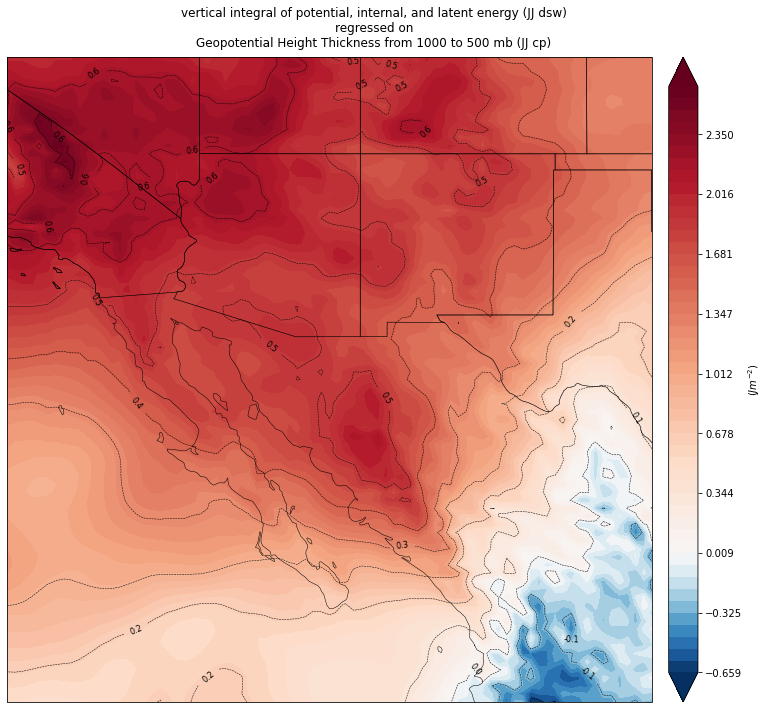

In [90]:
# test cell to copmute and plot regression data

# required arguments
var1 = 'z_thick_1000-500'
var1_months = [6, 7]
var1_region = 'cp'
var2 = 'vipile'
var2_months = [6, 7]
var2_region = 'dsw'

# optional variable arguments
var_kwargs = {
    'var1_level': 500,
    'var2_level': 500,
}

# other optional arguments
other_kwargs = {
    'detrend_type': 'zscore',
    'time_group': 'year',
    # 'dim_means': [],
    'show_png': True,
    'save_png': False,
    'save_nc': False,
    'overwrite_flag': False,
}

if __name__ == '__main__':
    kwargs = other_kwargs.copy()

    if var1 in pl_var_list:
        kwargs.update({'var1_level': var_kwargs['var1_level']})
    if var2 in pl_var_list:
        kwargs.update({'var2_level': var_kwargs['var2_level']})

    main(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs)

In [ ]:
# # test cell to compare detrend types
# # required arguments
# var1 = 'nino-3'
# var1_months = [3, 4, 5]
# var1_region = 'dsw'
# var2 = 'precipitation'
# var2_months = [6, 7, 8, 9, 10]
# var2_region = 'dsw'

# # optional variable arguments
# var_kwargs = {
#     'var1_level': 500,
#     'var2_level': 500,
# }

# # other optional arguments
# other_kwargs = {
#     'detrend_type': '',
#     'time_group': 'year',
#     # 'dim_means': [],
#     'show_png': True,
#     'save_png': False,
#     'save_nc': False,
#     'overwrite_flag': False,
# }

# detrend_types = ['', 'deseasonalize', 'zscore']

# if __name__ == '__main__':
#     for detrend_type in detrend_types:
#         kwargs = other_kwargs.copy()
#         kwargs['detrend_type'] = detrend_type

#         if var1 in pl_var_list:
#             kwargs.update({'var1_level': var_kwargs['var1_level']})
#         if var2 in pl_var_list:
#             kwargs.update({'var2_level': var_kwargs['var2_level']})

#         main(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs)

In [22]:
# optional variable arguments
var_kwargs = {
    'var1_level': 500,
    'var2_level': 500,
}

# other optional arguments
other_kwargs = {
    'detrend_type': '',
    'time_group': 'year',
    # 'dim_means': [],
    'show_png': True,
    'save_png': False,
    'save_nc': False,
    'overwrite_flag': False,
}

detrend_types = ['', 'deseasonalize', 'zscore']

In [ ]:
# # cell to copmute and plot regression data
# # required inputs
# var1_list = ['stl1', 'sd', 'swvl1', 'sstk']
# var1_region = 'cp'
# var1_months_list = [[3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]

# var2_list = ['sshf', 'slhf']
# var2_region = 'dsw'
# var2_months = [6, 7, 8]

# if __name__ == '__main__':
#     for detrend_type in detrend_types:
#         for var1 in var1_list:
#             for var1_months in var1_months_list:
#                 for var2 in var2_list:
#                     kwargs = other_kwargs.copy()
#                     kwargs['detrend_type'] = detrend_type
#                     if var1 in pl_var_list:
#                         kwargs.update({'var1_level': var_kwargs['var1_level']})
#                     if var2 in pl_var_list:
#                         kwargs.update({'var2_level': var_kwargs['var2_level']})

#                     print(f'detrend_type: {detrend_type}\tvar1: {var1} - {var1_months}\t-\tvar2: {var2}')
#                     if var1 == 'sstk':
#                         main(var1, var1_months, 'baja', var2, var2_months, var2_region, **kwargs)
#                     else:
#                         main(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs)

In [ ]:
# cell to copmute and plot regression data
# required inputs
var1_list = ['stl1', 'sstk', 'sshf', 'slhf', 'sd', 'swvl1', 'nino-3']
var1_region = 'cp'
var1_months_list = [[3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]

var2_list = ['z_height', 'z_thick_1000-500', 'msl', 'tp', 'onset', 'retreat', 'length', 'precipitation', 'precipitation-rate']
var2_region = 'dsw'
var2_months = [6, 7, 8]

if __name__ == '__main__':
    for detrend_type in detrend_types:
        for var1 in var1_list:
            for var1_months in var1_months_list:
                for var2 in var2_list:
                    kwargs = other_kwargs.copy()
                    kwargs['detrend_type'] = detrend_type
                    if var1 in pl_var_list:
                        kwargs.update({'var1_level': var_kwargs['var1_level']})
                    if var2 in pl_var_list:
                        kwargs.update({'var2_level': var_kwargs['var2_level']})

                    print(f'detrend_type: {detrend_type}\tvar1: {var1} - {var1_months}\t-\tvar2: {var2}')
                    if var1 == 'sstk':
                        main(var1, var1_months, 'baja', var2, var2_months, var2_region, **kwargs)
                    else:
                        main(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs)

In [ ]:
# cell to copmute and plot regression data
# required inputs
var1_list = ['z_height', 'z_thick_1000-500', 'msl', 'nino-3']
var1_region = 'cp'
var1_months_list = [[3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]

var2_list = ['tp', 'onset', 'retreat', 'length', 'precipitation', 'precipitation-rate']
var2_region = 'dsw'
var2_months = [6, 7, 8]

if __name__ == '__main__':
    for detrend_type in detrend_types:
        for var1 in var1_list:
            for var1_months in var1_months_list:
                for var2 in var2_list:
                    kwargs = other_kwargs.copy()
                    kwargs['detrend_type'] = detrend_type
                    if var1 in pl_var_list:
                        kwargs.update({'var1_level': var_kwargs['var1_level']})
                    if var2 in pl_var_list:
                        kwargs.update({'var2_level': var_kwargs['var2_level']})

                    print(f'detrend_type: {detrend_type}\tvar1: {var1} - {var1_months}\t-\tvar2: {var2}')
                    if var1 == 'sstk':
                        main(var1, var1_months, 'baja', var2, var2_months, var2_region, **kwargs)
                    else:
                        main(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs)

In [ ]:
# # cell to copmute and plot regression data
# # required inputs
# var1_list = ['onset', 'retreat', 'length']
# var1_region = 'cp'
# var1_months_list = [[3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]

# var2_list = ['tp', 'precipitation', 'precipitation-rate']
# var2_region = 'dsw'
# var2_months = [6, 7, 8]

# if __name__ == '__main__':
#     for detrend_type in detrend_types:
#         for var1 in var1_list:
#             for var1_months in var1_months_list:
#                 for var2 in var2_list:
#                     kwargs = other_kwargs.copy()
#                     kwargs['detrend_type'] = detrend_type
#                     if var1 in pl_var_list:
#                         kwargs.update({'var1_level': var_kwargs['var1_level']})
#                     if var2 in pl_var_list:
#                         kwargs.update({'var2_level': var_kwargs['var2_level']})

#                     print(f'detrend_type: {detrend_type}\tvar1: {var1} - {var1_months}\t-\tvar2: {var2}')
#                     if var1 == 'sstk':
#                         main(var1, var1_months, 'baja', var2, var2_months, var2_region, **kwargs)
#                     else:
#                         main(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs)

In [ ]:
# # cell to copmute and plot regression data
# # required inputs
# var1_list = ['onset', 'retreat', 'length']
# var1_region = 'dsw'
# var1_months_list = [[3, 4, 5], [4, 5, 6], [5, 6, 7], [6, 7, 8]]

# var2_list = ['tp', 'precipitation', 'precipitation-rate']
# var2_region = 'dsw'
# var2_months = [6, 7, 8]

# if __name__ == '__main__':
#     for detrend_type in detrend_types:
#         for var1 in var1_list:
#             for var1_months in var1_months_list:
#                 for var2 in var2_list:
#                     kwargs = other_kwargs.copy()
#                     kwargs['detrend_type'] = detrend_type
#                     if var1 in pl_var_list:
#                         kwargs.update({'var1_level': var_kwargs['var1_level']})
#                     if var2 in pl_var_list:
#                         kwargs.update({'var2_level': var_kwargs['var2_level']})

#                     print(f'detrend_type: {detrend_type}\tvar1: {var1} - {var1_months}\t-\tvar2: {var2}')
#                     if var1 == 'sstk':
#                         main(var1, var1_months, 'baja', var2, var2_months, var2_region, **kwargs)
#                     else:
#                         main(var1, var1_months, var1_region, var2, var2_months, var2_region, **kwargs)